# Notes:

1. Extract data from Port Buffer (Do not re-run)
2. Create Routes p1
3. <b>Create Routes p2 and Validate Vessel Information</b>
4. Update Departures Draught Info Update Departures Draught Info
5. Extract to Local
6. Trade Estimation (Local)

Set-up: UNGP - kernel `ais-tt-dev`

From the 2nd notebook, there may be routes that are quick because of small movements by vessels located at the edges of the boundaries. To remove the noise, we say that a vessel has fully exited the port when it spends at least 1 day outside of Port Boundary. Otherwise, we treat consecutive routes within 24 hours of each other as one. We then combine the routes data with Ship Registry data to get the finer vessel categories and other information on the vessel required for trade estimation. The matching is done using both MMSI and IMO numbers from both data sources. We validate the match by comparing the vessel names. 

The routes are also refined further to get only
1. routes from individual vessels based on MMSI
2. routes containing more than 1 AIS signal to address data quality issue during early 2020

# Initializers

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
pd.set_option('display.max_columns', None) #Show all columns in pandas df
pd.set_option('display.max_rows', 100) #Show 100 rows in pandas df
pd.options.display.float_format = '{:.10f}'.format #Show float with 10 decimal points in pandas df

from IPython.core.interactiveshell import InteractiveShell #allow multiple outputs in one jupyter cell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
#name comparison
!pip install nltk

Closing down clientserver connection
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.7/782.7 kB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 41.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [4]:
#for comparison of strings
import nltk

## Variables

In [22]:
bucket = 'ungp-ais-data-historical-backup'
s3path = "s3a://ungp-ais-data-historical-backup/user_temp/"

wb_path = f"{s3path}worldbank/"

path_syr = f"{wb_path}syria-buffer/"
path_port_calls = f"{wb_path}syria_port_calls/"

ihs_basepath = "s3a://ungp-ais-data-historical-backup/register/"
ihs_basepath_archive = "s3a://ungp-ais-data-historical-backup/register-archive/"

# Routes

In [23]:
sdf = spark.read.option("basePath",path_syr).parquet(path_syr)

In [24]:
df = sdf.toPandas()

In [21]:
len(df)

3971

In [25]:
len(df)

1954

In [26]:
df.head(2)

,mmsi,route_group,polygon_name,imo,flag_country,vessel_name,vessel_type,vessel_type_main,vessel_type_sub,arrival_dt_pos_utc,arrival_draught,arrival_destination,arrival_length,arrival_width,arrival_heading,count_ais,max_draught,min_draught,mean_draught,max_sog,min_sog,mean_sog,departure_dt_pos_utc,departure_draught,departure_destination,departure_length,departure_width,departure_heading,year,month
0,215029000.0000000000,0,Tartus,9575292.0000000000,Malta,MUBARIZ IBRAHIMOV,Tanker,Oil And Chemical Tanker,Chemical Oil Products Tanker,2019-07-11 20:05:04,4.0000000000,FOR ORDERS,140.0000000000,16.0000000000,216.0000000000,1.0000000000,4.0000000000,4.0000000000,4.0000000000,0.2000000000,0.2000000000,0.2000000000,2019-07-11 20:05:04,4.0000000000,FOR ORDERS,140.0000000000,16.0000000000,216.0000000000,2019.0000000000,7.0000000000
1,215421000.0000000000,0,Al Ladhiqiyah,9226516.0000000000,Malta,CINZIA A,Cargo,None,None,2019-07-30 01:06:04,10.4000000000,SYLTK,200.0000000000,30.0000000000,105.0000000000,156.0000000000,10.4000000000,10.0000000000,10.3897435897,16.3000000000,0.0000000000,0.7070512821,2019-07-31 12:23:41,10.0000000000,TRISK,200.0000000000,30.0000000000,270.0000000000,2019.0000000000,7.0000000000


In [27]:
df.loc[:, "width"] = df.loc[:, "departure_width"]
df.loc[:, "length"] = df.loc[:, "departure_length"]
df.loc[:, "Port"] = df.loc[:, "polygon_name"]
df.loc[:, "Country"] = "Syria"

In [28]:
# df = pd.concat([pd.read_pickle(f"{path_route}{country}/{year}.pkl") for year in [2019,2020,2021,2022,2023] for country in country_list], ignore_index=True)
# df.info()

In [29]:
# df.Country.unique()

In [30]:
# df[df['Country Buffer'] != df['Country']]

In [31]:
# df.groupby(['Country','Port']).size()

In [32]:
#Keep only routes within the IMF boundary
#NOTE REASSIGNMENT OF VARIABLE

# df = df[~df['Country'].isnull()].copy()

In [33]:
df.shape

(1954, 34)

In [34]:
df['date'] = df['arrival_dt_pos_utc'].dt.floor('d')

From Samoa notebook

## Route aggregation

In [35]:
def agg_per_group(df_, group_col, ship_col):
    """
    Aggregates pre-defined columns from a pandas dataframe based on supplied unique identifiers
    
    group_col: list of columns for unique identifier of routes
    ship_col: list of columns for unique identifier of ships


    returns: Dataframe with aggregated columns
    
    gets the first occurence by group_col
                                
    get the last occurence by group_col
                
    get summary statistics according to aggregation function by group_col
    
    time_travel = time difference between previous route departre_dt_pos_utc and current route arrival_dt_pos_utc
    sorting according to ship_col 
    
    """
    df = df_.sort_values(group_col + ['arrival_dt_pos_utc'],ignore_index=True)
    
    df['tot_sog'] = df['mean_sog'] * df['count_ais']

    df_agg = df.groupby(group_col, dropna=False).agg({x:'first' for x in ["length","width","vessel_type",
                                                            "arrival_dt_pos_utc","arrival_draught","arrival_destination"
                                                            ]
                                       }).join(df.groupby(group_col, dropna=False).agg({'count_ais':'sum',
                                                                          'tot_sog':'sum',
                                                                          'max_sog':'max',
                                                                          'min_sog':'min'})
                                              ).join(df.groupby(group_col, dropna=False).agg({x:'last' for x in ['departure_dt_pos_utc','departure_draught','departure_destination',
                                                                                                  ]}))
        
    df_agg['mean_sog'] = df_agg['tot_sog'] / df_agg['count_ais']

    df_agg['time_spent'] = df_agg['departure_dt_pos_utc'] - df_agg['arrival_dt_pos_utc']
    
    df_agg = df_agg.drop(columns=['tot_sog']).reset_index()
    
    df_agg.sort_values(ship_col + ['arrival_dt_pos_utc'], inplace=True, ignore_index=True)
    df_agg['prev_departure_dt_pos_utc'] = df_agg.groupby(ship_col)['departure_dt_pos_utc'].shift(1)
    df_agg['time_travel'] = df_agg['arrival_dt_pos_utc'] - df_agg['prev_departure_dt_pos_utc']
    
    df_agg['year'] = df_agg['arrival_dt_pos_utc'].dt.year
    df_agg['month'] = df_agg['arrival_dt_pos_utc'].dt.month
    df_agg['date'] = df_agg['arrival_dt_pos_utc'].dt.floor('d')
   
    
    return df_agg

In [36]:
df.polygon_name.unique()

array(['Tartus', 'Al Ladhiqiyah'], dtype=object)

In [37]:
ports = ['Tartus', 'Al Ladhiqiyah']

In [38]:
df.columns

Index(['mmsi', 'route_group', 'polygon_name', 'imo', 'flag_country',
       'vessel_name', 'vessel_type', 'vessel_type_main', 'vessel_type_sub',
       'arrival_dt_pos_utc', 'arrival_draught', 'arrival_destination',
       'arrival_length', 'arrival_width', 'arrival_heading', 'count_ais',
       'max_draught', 'min_draught', 'mean_draught', 'max_sog', 'min_sog',
       'mean_sog', 'departure_dt_pos_utc', 'departure_draught',
       'departure_destination', 'departure_length', 'departure_width',
       'departure_heading', 'year', 'month', 'width', 'length', 'Port',
       'Country', 'date'],
      dtype='object')

In [39]:
## include only mmsi for individual ships: MIDxxxxxx, where MID from 200-799
## - https://en.wikipedia.org/wiki/Maritime_Mobile_Service_Identity#Station_Identity_Formats
cond = (df.mmsi >= 200000000) & (df.mmsi <= 799999999)

#keep only routes within ports
cond2 = df['polygon_name'].isin(ports)

#aggregate routes within the day into one
group_col = ["mmsi","imo","vessel_name","year","month","date","Port"]
ship_col = ["mmsi","imo","vessel_name"]
df_agg = agg_per_group(df[cond & cond2], group_col, ship_col)
 
print(f"""
Raw routes  --------
{df.groupby('year').agg({'route_group':'count','mmsi':'nunique'})}

Keep only routes within Apia -----
{df[cond2].groupby('year').agg({'route_group':'count','mmsi':'nunique'})}

Include only individual ships -----
{df[cond & cond2].groupby('year').agg({'route_group':'count','mmsi':'nunique'})}

Aggregate routes within the day ----
{df_agg.groupby('year').agg({'date':'count','mmsi':'nunique'})}
""")


Raw routes  --------
                 route_group  mmsi
year                              
2019.0000000000          430   179
2020.0000000000          412   153
2021.0000000000          357   119
2022.0000000000          245    81
2023.0000000000          249    94
2024.0000000000          254   119

Keep only routes within Apia -----
                 route_group  mmsi
year                              
2019.0000000000          430   179
2020.0000000000          412   153
2021.0000000000          357   119
2022.0000000000          245    81
2023.0000000000          249    94
2024.0000000000          254   119

Include only individual ships -----
                 route_group  mmsi
year                              
2019.0000000000          427   177
2020.0000000000          412   153
2021.0000000000          349   118
2022.0000000000          245    81
2023.0000000000          249    94
2024.0000000000          249   116

Aggregate routes within the day ----
      date  mmsi
year      

In [40]:
df_agg['time_travel_flag'] = np.where((df_agg.time_travel <= "1 days") & ~(df_agg.time_travel.isnull()), 0, 1)
df_agg['new_route_group'] = df_agg.groupby(ship_col).time_travel_flag.cumsum()

In [41]:
df_agg['time_travel_flag'] = np.where((df_agg.time_travel <= "1 days") & ~(df_agg.time_travel.isnull()), 0, 1)
df_agg['new_route_group'] = df_agg.groupby(ship_col).time_travel_flag.cumsum()

group_col = ["mmsi","imo","vessel_name", "new_route_group", "Port"]
df_agg = agg_per_group(df_agg, group_col, ship_col)


cond = df_agg.count_ais > 1
print(f"""
Aggregate routes where time in between is less than 1 day ----
{df_agg.groupby('year').agg({'new_route_group':'count','mmsi':'nunique'})}

Remove routes with only 1 AIS signal ----
{df_agg[cond].groupby('year').agg({'new_route_group':'count','mmsi':'nunique'})}

""")


Aggregate routes where time in between is less than 1 day ----
      new_route_group  mmsi
year                       
2019              393   177
2020              381   152
2021              328   117
2022              225    81
2023              232    94
2024              230   115

Remove routes with only 1 AIS signal ----
      new_route_group  mmsi
year                       
2019              334   152
2020              324   131
2021              294   102
2022              194    64
2023              196    74
2024              181    69




In [42]:
# df_agg.head(3)

generated new fontManager


<Axes: title={'center': 'AIS Routes Raw'}, xlabel='arrival_dt_pos_utc'>

<Axes: title={'center': 'AIS Routes Raw'}, xlabel='arrival_dt_pos_utc'>

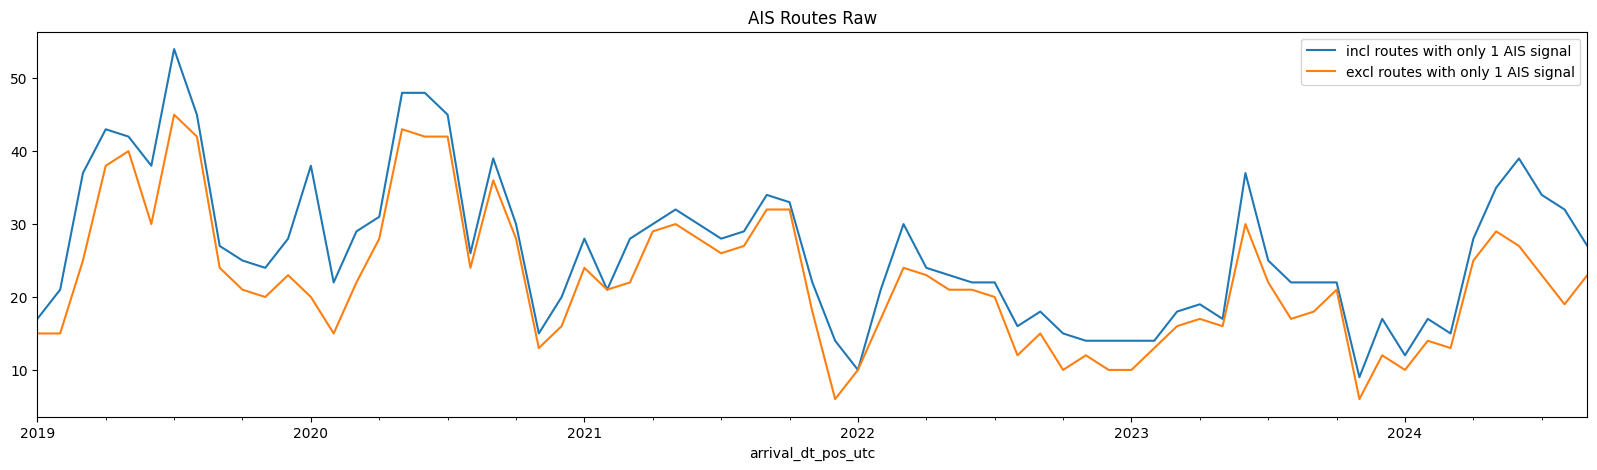

In [43]:
#Sketchy Jan 2020 data, fixed by removing routes with only 1 AIS signal
df_agg.set_index('arrival_dt_pos_utc').groupby(pd.Grouper(freq="M")).mmsi.count().rename("incl routes with only 1 AIS signal").plot(figsize=(20,5), title="AIS Routes Raw",
                                                                                                                                   legend=True)
df_agg[cond].set_index('arrival_dt_pos_utc').groupby(pd.Grouper(freq="M")).mmsi.count().rename("excl routes with only 1 AIS signal").plot(legend=True)

In [44]:
#warning reassign variable
df_agg = df_agg[cond].reset_index(drop=True)

In [45]:
print(f"""
We have reduced the routes data from {df.shape[0]:,} to {df_agg.shape[0]:,}.
""")


We have reduced the routes data from 1,954 to 1,538.



# Ship Register Data

In [46]:
#latest available version in ungp
ihs_version = pd.read_csv(ihs_basepath+"version.csv")
ihs_version

Found credentials from IAM Role: eksctl-sparky-mc-sparkface-nodegr-NodeInstanceRole-15Y58CLME2WUS


,20240930


In [47]:
#Check Column list
ihs_columns = pd.read_csv(ihs_basepath+"ShipData.CSV", nrows=2).columns.tolist()
ihs_columns

['LRIMOShipNo',
 'StatCode5',
 'AlterationsDescriptiveNarrative',
 'PropulsionTypeCode',
 'ShipName',
 'ExName',
 'MaritimeMobileServiceIdentityMMSINumber',
 'RegisteredOwnerCode',
 'RegisteredOwnerCountryOfRegistration',
 'RegisteredOwnerCountryofDomicile',
 'ShipManagerCompanyCode',
 'ShipManagerCountryOfRegistration',
 'ShipManagerCountryofDomicileName',
 'GroupBeneficialOwnerCompanyCode',
 'GroupBeneficialOwnerCountryOfRegistration',
 'GroupBeneficialOwnerCountryofDomicile',
 'OperatorCompanyCode',
 'OperatorCountryOfRegistration',
 'OperatorCountryofDomicileName',
 'FlagCode',
 'PortofRegistryCode',
 'Tonnagesystem69convention',
 'GrossTonnage',
 'Deadweight',
 'LengthOverallLOA',
 'LengthBetweenPerpendicularsLBP',
 'LengthRegistered',
 'DateOfBuild',
 'ShipbuilderCompanyCode',
 'YardNumber',
 'NumberofDecks',
 'HoldsDescriptiveNarrative',
 'TanksDescriptiveNarrative',
 'NumberofHatches',
 'NumberofHolds',
 'NumberofTanks',
 'InsulatedCapacity',
 'TEU',
 'NumberofMainEngines',
 'P

In [48]:
 # from ShipData (FACT Table) get only relevant columns
ihs = pd.read_csv(ihs_basepath+"ShipData.CSV", usecols=['StatCode5','LRIMOShipNo','MaritimeMobileServiceIdentityMMSINumber',
                                                        'ShipName','ExName','TEU',
                                                        'Draught','Deadweight','NetTonnage','GrossTonnage','Displacement','LightDisplacementTonnage',
                                                        'LengthOverallLOA','LengthRegistered','BreadthExtreme','BreadthMoulded'])


ihs.rename(columns={'MaritimeMobileServiceIdentityMMSINumber':'mmsi','LRIMOShipNo':'imo'}, inplace=True)

ihs.shape
#Big file, keep only where imo or mmsi is ins the ais data
ihs = ihs[ihs.imo.isin(df_agg.imo) | ihs.mmsi.isin(df_agg.mmsi)].reset_index(drop=True)

ihs.info()
ihs.head()

(260884, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   imo                       369 non-null    int64  
 1   StatCode5                 369 non-null    object 
 2   ShipName                  369 non-null    object 
 3   ExName                    337 non-null    object 
 4   mmsi                      301 non-null    float64
 5   GrossTonnage              369 non-null    int64  
 6   Deadweight                369 non-null    int64  
 7   LengthOverallLOA          369 non-null    float64
 8   LengthRegistered          369 non-null    float64
 9   TEU                       369 non-null    int64  
 10  BreadthExtreme            369 non-null    float64
 11  BreadthMoulded            369 non-null    float64
 12  Displacement              369 non-null    int64  
 13  Draught                   369 non-null    float64
 14  LightDispl

,imo,StatCode5,ShipName,ExName,mmsi,GrossTonnage,Deadweight,LengthOverallLOA,LengthRegistered,TEU,BreadthExtreme,BreadthMoulded,Displacement,Draught,LightDisplacementTonnage,NetTonnage
0,1054149,B34B2SC,MSN 6,Ao Li Deng 6,312514000.0000000000,1227,0,49.5000000000,46.6200000000,0,0.0000000000,18.6000000000,0,1.4000000000,0.0000000000,368
1,4568397,B31A2SR,BAT GALIM,Bant (Y867),428067000.0000000000,387,406,33.5400000000,0.0000000000,0,0.0000000000,9.2000000000,457,3.7000000000,0.0000000000,116
2,4727747,X11C2AS,SB-738,NaN,273544130.0000000000,0,0,57.0000000000,0.0000000000,0,0.0000000000,14.0000000000,1200,3.2000000000,0.0000000000,0
3,4751047,X11C2AS,SPASATEL VASILY BEKH,SB-739,273542830.0000000000,0,0,57.0000000000,0.0000000000,0,0.0000000000,14.0000000000,1200,3.2000000000,0.0000000000,0
4,4751059,X11C2AS,SB-742,NaN,273548340.0000000000,0,0,57.0000000000,0.0000000000,0,0.0000000000,14.0000000000,1200,3.2000000000,0.0000000000,0


In [49]:
# from Ship Type Code (Dimension Table) get only relevant columns
ihs_statcode = pd.read_csv(ihs_basepath + "tblShipTypeCodes.CSV", usecols=['StatCode5',
                                                                           'SubType',
                                                                           'SubGroup',
                                                                           'HullType',
                                                                           'ShiptypeLevel1',
                                                                           'ShipTypeLevel2',
                                                                           'ShipTypeLevel3',
                                                                           'ShipTypeLevel4',
                                                                           'ShiptypeLevel5'
                                                                          ]
                                                                           )

#Big file, keep only where imo or mmsi is ins the ais data
ihs_statcode = ihs_statcode[ihs_statcode['StatCode5'].isin(ihs.StatCode5)].reset_index(drop=True)

ihs_statcode.info()
ihs_statcode.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   StatCode5       22 non-null     object
 1   ShiptypeLevel5  22 non-null     object
 2   ShipTypeLevel4  22 non-null     object
 3   ShipTypeLevel3  22 non-null     object
 4   ShipTypeLevel2  22 non-null     object
 5   ShiptypeLevel1  22 non-null     object
 6   HullType        22 non-null     object
 7   SubGroup        22 non-null     object
 8   SubType         22 non-null     object
dtypes: object(9)
memory usage: 1.7+ KB


,StatCode5,ShiptypeLevel5,ShipTypeLevel4,ShipTypeLevel3,ShipTypeLevel2,ShiptypeLevel1,HullType,SubGroup,SubType
0,A12B2TR,Chemical/Products Tanker,Chemical/Oil Products Tanker,Chemical,Tankers,Cargo Carrying,Ship Shape Including Multi-Hulls,Tanker Products,Chemical/Products Tanker
1,A12D2LV,Vegetable Oil Tanker,Vegetable Oil Tanker,Chemical,Tankers,Cargo Carrying,Ship Shape Including Multi-Hulls,Liquid Cargo,Vegetable Oil Tanker
2,A13B2TP,Products Tanker,Oil Products Tanker,Oil,Tankers,Cargo Carrying,Ship Shape Including Multi-Hulls,Tanker Products,Products Tanker
3,A21A2BC,Bulk Carrier,Bulk Carrier,Bulk Dry,Bulk Carriers,Cargo Carrying,Ship Shape Including Multi-Hulls,Dry Bulk Cargo,Bulk Carrier
4,A24A2BT,Cement Carrier,Cement Carrier,Other Bulk Dry,Bulk Carriers,Cargo Carrying,Ship Shape Including Multi-Hulls,Dry Bulk Cargo,Cement Carrier


In [50]:
ihs_name = pd.read_csv(ihs_basepath + "tblNameHistory.CSV").rename(columns={'LRNO':'imo'}).sort_values(['imo','Effective_Date'], ascending=False)
ihs_name = ihs_name[ihs_name['imo'].isin(df_agg['imo'].dropna().unique())]

ihs_name['year'] = ihs_name['Effective_Date'].astype('str').str[:4]
ihs_name['month'] = ihs_name['Effective_Date'].astype('str').str[4:6]


ihs_name.info()
ihs_name.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1813 entries, 564778 to 15595
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   imo             1813 non-null   int64 
 1   Sequence        1813 non-null   int64 
 2   VesselName      1813 non-null   object
 3   Effective_Date  1813 non-null   int64 
 4   year            1813 non-null   object
 5   month           1813 non-null   object
dtypes: int64(3), object(3)
memory usage: 99.1+ KB


,imo,Sequence,VesselName,Effective_Date,year,month
564778,9985021,0,VENTO DI MAESTRALE,202403,2024,03
564779,9985021,95,Kalliroe C,202401,2024,01
560740,9950064,0,VENTO DI BORA,202303,2023,03
560741,9950064,95,Cape Ben,202302,2023,02
557955,9924340,0,ALPHA HELIOS,202107,2021,07


In [51]:
ihs_name.year.unique()
ihs_name.month.unique()

array(['2024', '2023', '2021', '2020', '2017', '2019', '2018', '2016',
       '2022', '2015', '2012', '2013', '2011', '2010', '2009', '2008',
       '2014', '2007', '2005', '2006', '2004', '2003', '2002', '2001',
       '2000', '1999', '1998', '1997', '1996', '1995', '1994', '1993',
       '1992', '1991', '1987', '1990', '1989', '1985', '1978', '1986',
       '1988', '1984', '1983', '1982', '1981', '1980', '1979', '1977',
       '1976', '1975', '1974', '1973', '1972', '1971', '1970', '1967',
       '1966', '1965', '1960'], dtype=object)

array(['03', '01', '02', '07', '06', '05', '12', '08', '04', '09', '11',
       '10', '00', '99'], dtype=object)

In [52]:
#create a datetime object from Effective Date. Assume first day of the month / year
ihs_name['month'] = ihs_name.month.replace("00","01").replace("99","01")
ihs_name['day'] ="01"
ihs_name['date'] = pd.to_datetime(ihs_name['year'] + ihs_name['month'] + ihs_name['day'])

ihs_name.sort_values(['imo','Sequence'], ascending=False, inplace=True, ignore_index=True)
ihs_name['next_date'] = ihs_name.groupby('imo').date.shift(-1).fillna(pd.to_datetime("20221231"))

In [53]:
ihs_name.drop_duplicates(subset=['imo','date'], keep='last', inplace=True)

In [54]:
 # index = ihs_name.groupby('imo')['VesselName'].agg(list).index
# ihs_name = pd.DataFrame(ihs_name.groupby('imo')['VesselName'].agg(list).to_list(), index=index)
ihs_name.info()
ihs_name.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1772 entries, 0 to 1812
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   imo             1772 non-null   int64         
 1   Sequence        1772 non-null   int64         
 2   VesselName      1772 non-null   object        
 3   Effective_Date  1772 non-null   int64         
 4   year            1772 non-null   object        
 5   month           1772 non-null   object        
 6   day             1772 non-null   object        
 7   date            1772 non-null   datetime64[ns]
 8   next_date       1772 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 138.4+ KB


,imo,Sequence,VesselName,Effective_Date,year,month,day,date,next_date
0,9985021,95,Kalliroe C,202401,2024,01,01,2024-01-01,2024-03-01
1,9985021,0,VENTO DI MAESTRALE,202403,2024,03,01,2024-03-01,2022-12-31
2,9950064,95,Cape Ben,202302,2023,02,01,2023-02-01,2023-03-01
3,9950064,0,VENTO DI BORA,202303,2023,03,01,2023-03-01,2022-12-31
4,9924340,0,ALPHA HELIOS,202107,2021,07,01,2021-07-01,2022-12-31


## Combine AIS and IHS


In [55]:
#keep the date of the first route for each unique ship
df_ships = df_agg.sort_values('date')[['date'] + ship_col] \
                .drop_duplicates(subset=ship_col,
                                 keep='first')
df_ships = df_ships.sort_values(ship_col, ignore_index=True).reset_index()

print(f"""
Aggregated routes: 
Unique MMSI: {df_ships['mmsi'].nunique()}
Unique IMO: {df_ships['imo'].nunique()}
Unique Vessel Name: {df_ships['vessel_name'].nunique()}
Unique MMSI x IMO X Vessel Name: {df_ships[ship_col].shape[0]}
""")


Aggregated routes: 
Unique MMSI: 393
Unique IMO: 365
Unique Vessel Name: 395
Unique MMSI x IMO X Vessel Name: 411



In [56]:
 def attach_ExName_on_Effdate(df, ihs_name):
    df2 = pd.merge_asof(df.sort_values(by=['date', 'ihs_imo']), 
              ihs_name[['imo','VesselName','date','next_date']].rename(columns={'imo':'ihs_imo',
                                                                                'VesselName':'ExName_perdate',
                                                                                'next_date':'ExName_eff_until_date'}).sort_values(by=['date','ihs_imo']),
              on = 'date',
              by = 'ihs_imo',
              direction = 'backward'
             )
    return df2

In [57]:
part1 = df_ships.merge(ihs, on=['imo','mmsi'], how='inner').merge(ihs_statcode) \
        .assign(match_ihs="imo x mmsi")

part1['ihs_imo'] = part1['imo'].astype('int')
part1 = attach_ExName_on_Effdate(part1, ihs_name)


part2 = df_ships[~df_ships['index'].isin(part1['index'].tolist()) & (df_ships.imo != 0)] \
                 .merge(ihs.rename(columns={'mmsi':'ihs_mmsi'}), on=['imo'], how='inner').merge(ihs_statcode) \
                 .assign(match_ihs="imo")
part2['ihs_imo'] = part2['imo'].astype('int')
part2 = attach_ExName_on_Effdate(part2, ihs_name)

part3 = df_ships[~df_ships['index'].isin(part1['index'].tolist()  \
                                         + part2['index'].tolist())] \
                .merge(ihs.rename(columns={'imo':'ihs_imo'}), on=['mmsi'], how='inner').merge(ihs_statcode) \
                .assign(match_ihs="mmsi")
part3 = attach_ExName_on_Effdate(part3, ihs_name)


part4 = df_ships[~df_ships['index'].isin(part1['index'].tolist() \
                                         + part2['index'].tolist() \
                                         + part3['index'].tolist())
                ].assign(match_ihs="no match")

In [58]:
pd.concat([part1,part2,part3, part4], ignore_index=True).shape
df_ships.shape

(411, 32)

(411, 5)

In [59]:
#WARNING- REASSIGN VARIABLE
df_ships = pd.concat([part1,part2,part3,part4], ignore_index=True)

In [60]:
df_ships.match_ihs.value_counts()
df_ships.shape[0]

imo x mmsi    227
imo           166
no match       10
mmsi            8
Name: match_ihs, dtype: int64

411

In [61]:
# df_ships.info()
df_ships.head(2)

,index,date,mmsi,imo,vessel_name,StatCode5,ShipName,ExName,GrossTonnage,Deadweight,LengthOverallLOA,LengthRegistered,TEU,BreadthExtreme,BreadthMoulded,Displacement,Draught,LightDisplacementTonnage,NetTonnage,ShiptypeLevel5,ShipTypeLevel4,ShipTypeLevel3,ShipTypeLevel2,ShiptypeLevel1,HullType,SubGroup,SubType,match_ihs,ihs_imo,ExName_perdate,ExName_eff_until_date,ihs_mmsi
0,63,2019-01-05,271044398.0000000000,9106493.0000000000,MED DENIZLI,A33A2CC,MED DENIZLI,MSC Clementina,10925.0000000000,13623.0000000000,151.4800000000,142.2100000000,1055.0000000000,0.0000000000,24.0000000000,19405.0000000000,8.2500000000,5782.0000000000,5548.0000000000,Container Ship (Fully Cellular),Container Ship,Container,Dry Cargo/Passenger,Cargo Carrying,Ship Shape Including Multi-Hulls,Cellular Container,Container Ship (Fully Cellular),imo x mmsi,9106493.0000000000,MED DENIZLI,2022-12-31,NaN
1,88,2019-01-10,273413510.0000000000,8814354.0000000000,PIZHMA,A31A2GX,PIZHMA,MCL Trader,3466.0000000000,4236.0000000000,95.0000000000,0.0000000000,0.0000000000,15.9000000000,15.8000000000,6325.0000000000,6.3100000000,2089.0000000000,1365.0000000000,General Cargo Ship,General Cargo Ship,General Cargo,Dry Cargo/Passenger,Cargo Carrying,Ship Shape Including Multi-Hulls,General Cargo,General Cargo,imo x mmsi,8814354.0000000000,PIZHMA,2022-12-31,NaN


## Validate matches

Validate matches by checking the vessel_name from AIS againt the ShipName / ExName from IHS

We apply a string similarity metric based on the Levenshtein distance from the nltk python package. The metric computes for the minimum number of edits (insertion, deletion, substitution) needed to transform one string into another string. To standardize the metric, we divide by the metric by the length of the longer string. The strings compared are the vessel name from AIS and Ship Name (or ExName, or ExName per date) from the Ship Register. From visual inspection of the scores, we set score <= 0.5 as a match.

In [62]:
def clean_string(dfseries):
    # return dfseries.str.replace(' +', '', regex=True).str.upper()
    return dfseries.str.replace('[^a-zA-Z]', '', regex=True).str.upper()

In [63]:
#sure proper matches 

#same AIS vessel name and IHS Ship Name (or exname, or previous exname
cond = (clean_string(df_ships['vessel_name']) != "") & \
        ((clean_string(df_ships['vessel_name']) == clean_string(df_ships['ShipName'])) | \
         (clean_string(df_ships['vessel_name']) == clean_string(df_ships['ExName'])) | \
         (clean_string(df_ships['vessel_name']) == clean_string(df_ships['ExName_perdate'])))

df_ships.loc[cond,"fin_match"] = "okay - match ship name"

#matched with imo & mmsi
cond =  (df_ships['match_ihs']== "imo x mmsi") & \
        df_ships['fin_match'].isnull()
df_ships.loc[cond,"fin_match"] = "okay - match imo x mmsi"

df_ships['fin_match'].value_counts()
df_ships['fin_match'].isnull().sum()

okay - match ship name     381
okay - match imo x mmsi      7
Name: fin_match, dtype: int64

23

In [64]:
#not validated match for  check comparison of vessel name with IHS names using fuzzy match
pd.options.display.float_format = '{:}'.format

df_ships[df_ships['fin_match'].isnull() & (df_ships['match_ihs']!= "no match") ] \
        [['ihs_imo','vessel_name','ShipName','ExName','ExName_perdate','match_ihs','fin_match']] \
        .drop_duplicates()

,ihs_imo,vessel_name,ShipName,ExName,ExName_perdate,match_ihs,fin_match
240,7528556.0,UNAVAILABLE,PRINCESS M,Princess Maria,Princess Maria,imo,NaN
284,8871003.0,M/T PAZAR,NIKSAR,Pazar,Pazar,imo,NaN
287,8204119.0,NARSIS,GAM EXPRESS,Agm Express,Haje Amira,imo,NaN
305,9155365.0,MV HANSA FLENSBURG,HANSA FLENSBURG,Melbourne Express,HANSA FLENSBURG,imo,NaN
322,8215754.0,NADALINA,EAST EXPRESS,Lady Abeer,Lady Abeer,imo,NaN
379,9460253.0,FLEET TRADER 2,MEUTIA BARUNA,Fleet Trader II,Fleet Trader II,imo,NaN
387,8915184.0,MUSTAFA K,SEA BREEZE,Thanh Son,SEA BREEZE,imo,NaN
389,5338892.0,CAPT.CHIDE,MICHELLE S,Starcrescent,MICHELLE S,imo,NaN
392,9055163.0,OCEAN 15,NADA,Ras Sedr,NADA,imo,NaN
393,4751047.0,RESCUE TUG SB-739,SPASATEL VASILY BEKH,SB-739,NaN,mmsi,NaN


In [65]:
#compute string match score
#levenshtein distance between two strings / length of longer string 
#levenshtein distance is minimum number of character edits (insert, delete, substitute) to change one string to another
df_ships['lev_ShipName'] = df_ships[['vessel_name','ShipName']].fillna("_").apply(lambda x: nltk.edit_distance(*x) / max(len(x[0]),len(x[1])), axis=1)

df_ships['lev_ExName'] = df_ships[['vessel_name','ExName']].fillna("_").apply(lambda x: nltk.edit_distance(x[0], x[1].upper()) / max(len(x[0]),len(x[1])), axis=1)
df_ships['lev_ExName_perdate'] = df_ships[['vessel_name','ExName_perdate']].fillna("_").apply(lambda x: nltk.edit_distance(x[0], x[1].upper()) / max(len(x[0]),len(x[1])), axis=1)

In [66]:
df_ships[df_ships['fin_match'].isnull() & (df_ships['match_ihs']!= "no match")]["lev_ShipName"].describe() 

count                  13.0
mean     0.8349705849705849
std     0.21670317536867284
min     0.16666666666666666
25%                    0.85
50%                   0.875
75%      0.9166666666666666
max                     1.0
Name: lev_ShipName, dtype: float64

In [67]:
#check appropriate maximum score, should be low
max_score = 0.5
df_ships[df_ships['fin_match'].isnull() & (df_ships['match_ihs']!= "no match")  & (df_ships['lev_ShipName'] > max_score - 0.1) & (df_ships['lev_ShipName'] <= max_score)] \
        [['ihs_imo','vessel_name','ShipName','ExName','ExName_perdate','match_ihs','fin_match', 'lev_ShipName']] \
        .drop_duplicates()

,ihs_imo,vessel_name,ShipName,ExName,ExName_perdate,match_ihs,fin_match,lev_ShipName


In [68]:
cond = (df_ships['lev_ShipName'] <= 0.5) & df_ships['fin_match'].isnull() & (df_ships['match_ihs']!= "no match")
df_ships.loc[cond,"fin_match"] = "okay - fuzzy match ship name"

cond = (df_ships['lev_ExName'] <= 0.5) & df_ships['fin_match'].isnull() & (df_ships['match_ihs']!= "no match")
df_ships.loc[cond,"fin_match"] = "okay - fuzzy match ship name"

cond = (df_ships['lev_ExName_perdate'] <= 0.5) & df_ships['fin_match'].isnull() & (df_ships['match_ihs']!= "no match")
df_ships.loc[cond,"fin_match"] = "okay - fuzzy match ship name"

df_ships['fin_match'].value_counts()
df_ships['fin_match'].isnull().sum()

okay - match ship name          381
okay - match imo x mmsi           7
okay - fuzzy match ship name      3
Name: fin_match, dtype: int64

20

In [69]:
pd.options.display.float_format = '{:}'.format

df_ships[(df_ships['fin_match']=="okay - fuzzy match ship name")] \
        [['ihs_imo','vessel_name','ShipName','ExName','ExName_perdate','match_ihs','fin_match', 'lev_ShipName','lev_ExName']] \
        .drop_duplicates()

,ihs_imo,vessel_name,ShipName,ExName,ExName_perdate,match_ihs,fin_match,lev_ShipName,lev_ExName
284,8871003.0,M/T PAZAR,NIKSAR,Pazar,Pazar,imo,okay - fuzzy match ship name,0.7777777777777778,0.4444444444444444
305,9155365.0,MV HANSA FLENSBURG,HANSA FLENSBURG,Melbourne Express,HANSA FLENSBURG,imo,okay - fuzzy match ship name,0.16666666666666666,0.8888888888888888
379,9460253.0,FLEET TRADER 2,MEUTIA BARUNA,Fleet Trader II,Fleet Trader II,imo,okay - fuzzy match ship name,0.8571428571428571,0.13333333333333333


In [70]:
#keep as not validated match
#we assume that the match with ship registry dataset is incorrect
df_ships[df_ships.fin_match.isnull() & (df_ships.match_ihs != "no match")] \
[['ihs_imo','vessel_name','ShipName','ExName','ExName_perdate','match_ihs','fin_match','lev_ShipName','lev_ExName','lev_ExName_perdate']]

,ihs_imo,vessel_name,ShipName,ExName,ExName_perdate,match_ihs,fin_match,lev_ShipName,lev_ExName,lev_ExName_perdate
240,7528556.0,UNAVAILABLE,PRINCESS M,Princess Maria,Princess Maria,imo,NaN,1.0,0.8571428571428571,0.8571428571428571
287,8204119.0,NARSIS,GAM EXPRESS,Agm Express,Haje Amira,imo,NaN,0.7272727272727273,0.8181818181818182,0.8
322,8215754.0,NADALINA,EAST EXPRESS,Lady Abeer,Lady Abeer,imo,NaN,0.9166666666666666,0.7,0.7
387,8915184.0,MUSTAFA K,SEA BREEZE,Thanh Son,SEA BREEZE,imo,NaN,1.0,1.0,1.0
389,5338892.0,CAPT.CHIDE,MICHELLE S,Starcrescent,MICHELLE S,imo,NaN,1.0,0.9166666666666666,1.0
392,9055163.0,OCEAN 15,NADA,Ras Sedr,NADA,imo,NaN,0.875,1.0,0.875
393,4751047.0,RESCUE TUG SB-739,SPASATEL VASILY BEKH,SB-739,NaN,mmsi,NaN,0.85,0.6470588235294118,1.0
394,4727747.0,SB PROF.NIKOLAY MURU,SB-738,NaN,NaN,mmsi,NaN,0.9,1.0,1.0
399,8003058.0,SHANGGAO,ITIDAL,Wakil Star,ITIDAL,mmsi,NaN,0.875,0.9,0.875
400,8918722.0,UNAVAILABLE,BOB,Princess Maysa,BOB,mmsi,NaN,0.9090909090909091,0.8571428571428571,0.9090909090909091


In [71]:
df_ships['match_ihs'].value_counts()

imo x mmsi    227
imo           166
no match       10
mmsi            8
Name: match_ihs, dtype: int64

In [72]:
print(f"""
Raw routes: {df_agg.shape[0]:,}
Matched using imo - mmsi logic: {df_agg.merge(df_ships[df_ships.match_ihs!= "no match"].drop(columns=['index','date'])).shape[0]:,}
Port calls (validated match with Ship Registry): {df_agg.merge(df_ships[~df_ships.fin_match.isnull()].drop(columns=['index','date'])).shape[0]:,}
""")


Raw routes: 1,538
Matched using imo - mmsi logic: 1,528
Port calls (validated match with Ship Registry): 1,516



In [73]:
port_calls = df_agg.merge(
                df_ships[~df_ships.fin_match.isnull()].drop(columns=['date','index']),
                on = ship_col,
                how='inner')

In [74]:
print(f"Unique ships in port call: {port_calls[ship_col].drop_duplicates().shape[0]}")

Unique ships in port call: 391


In [75]:
path_port_calls

's3a://ungp-ais-data-historical-backup/user_temp/worldbank/syria_port_calls/'

In [76]:
port_calls.to_pickle(f"{path_port_calls}port_calls_10142024.pkl")

In [77]:
len(port_calls)

1516